In [57]:
import os
os.chdir("/Users/nickl/Documents/College/DATA 481 - Gene Data")

In [58]:
import pandas as pd
normdf = pd.read_csv("normalized_expression.csv") #loading dataset
mapdf = pd.read_csv("gene_mappings.csv") #loading mappings dataset
metadf = pd.read_csv("metadata.csv") #loading metadata dataset

In [59]:
#merging mapping df with gene expression df
normdf.rename(columns={'Unnamed: 0': 'ENSEMBLID'}, inplace=True)
normdf = pd.merge(normdf, mapdf, on =  "ENSEMBLID", how='left')
normdf.set_index("ENSEMBLID", inplace=True)
normdf.head()


,TCGA-B6-A0IG-01A-11R-A034-07,TCGA-BH-A0HQ-01A-11R-A034-07,TCGA-BH-A18G-01A-11R-A12D-07,TCGA-A8-A09K-01A-11R-A00Z-07,TCGA-BH-A0BZ-01A-31R-A12P-07,TCGA-A1-A0SD-01A-11R-A115-07,TCGA-A1-A0SF-01A-11R-A144-07,TCGA-A1-A0SI-01A-11R-A144-07,TCGA-A1-A0SJ-01A-11R-A084-07,TCGA-A1-A0SK-01A-12R-A084-07,...,TCGA-41-2572-01A-01R-1850-01,TCGA-06-0138-01A-02R-1849-01,TCGA-06-0211-01A-01R-1849-01,TCGA-06-0178-01A-01R-1849-01,TCGA-28-2499-01A-01R-1850-01,TCGA-06-1804-01A-01R-1849-01,TCGA-26-1442-01A-01R-1850-01,TCGA-28-1747-01C-01R-1850-01,GENESYMBOL,GENETYPE
ENSEMBLID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,11.643945,12.660240,12.011286,10.902371,9.778870,11.086341,13.304347,11.204773,12.835616,12.470305,...,12.294185,12.843887,12.083013,13.196523,13.764084,11.588476,12.021739,12.586284,TSPAN6,protein_coding
ENSG00000000005,3.527251,1.141077,0.000000,2.923184,3.371978,5.487672,3.474578,2.517265,7.229333,0.000000,...,3.783844,5.468667,3.113357,3.538314,3.256006,2.887933,2.922775,3.424977,TNMD,protein_coding
ENSG00000000419,11.004391,10.379188,10.492609,10.625022,12.325179,11.250164,10.834781,11.193174,12.695187,11.631386,...,10.692166,11.044221,10.430246,11.321920,10.528515,10.027390,10.016298,10.270992,DPM1,protein_coding
ENSG00000000457,10.216685,10.975065,10.788455,11.340000,10.827489,10.294248,10.472310,11.166237,10.304750,9.737110,...,8.542477,9.221241,8.977203,10.255138,8.946696,8.857296,9.003882,9.138294,SCYL3,protein_coding
ENSG00000000460,9.076165,9.584343,9.316149,8.781399,9.825582,8.366424,8.994853,10.627795,9.219602,10.100473,...,8.379882,8.966339,8.967783,10.208429,7.872731,7.985417,7.840538,8.497433,C1orf112,protein_coding


In [60]:
print(normdf.shape)

(60616, 785)


In [61]:
#filtering for only protein coding genes
fnormdf = normdf.loc[normdf["GENETYPE"] == "protein_coding", :]
print(fnormdf.shape)

(19944, 785)


In [62]:
tnormdf = fnormdf.T
print(tnormdf.shape)

(785, 19944)


In [63]:
#Removing all genes with over 50% zeroes
zero_proportion = (tnormdf == 0).sum() / (len(tnormdf) - 2) #subtracted 2 because of the added 2 columns for gene mapping

no0df = tnormdf.loc[:, zero_proportion < 0.5]

no0df.shape

(785, 17349)

In [64]:
#Removing all genes with means less than 10
genemaprows = no0df.loc[["GENETYPE","GENESYMBOL"]]
fltno0df = no0df.drop(["GENETYPE", "GENESYMBOL"])
colmeans = fltno0df.mean(axis = 0)
filtereddf = fltno0df.loc[:,colmeans >= 10]
print(filtereddf.shape)


(783, 8094)


In [65]:
#taking top 2000 columns with highest variances
import numpy as np
variances = np.var(filtereddf, axis=0)
filtereddf.loc['variances'] = variances
filtereddf = filtereddf.sort_values(by='variances', axis=1, ascending=False)
finaldf = filtereddf.iloc[:, 0:2000]
print(finaldf.shape)
finaldf = finaldf.drop(index = "variances")


C:\Users\nickl\AppData\Local\Temp\ipykernel_11164\3561000705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtereddf.loc['variances'] = variances


(784, 2000)


In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [67]:
#Removes all rows with NAs in the ER col from metadf
metadf.set_index("mRNA", inplace=True)
ERmetadf = metadf.dropna(subset=['ER'])
ERfinaldf = finaldf.loc[ERmetadf.index] #Removes all rows with NA ER values from finaldf

In [68]:
ERfinaldf.shape
#ERfinaldf = ERfinaldf.reindex(ERmetadf.index) #Reindexes ERfinaldf to ensure it is in the same order as ERmetadf

(672, 2000)

In [69]:
import matplotlib.patches as mpatches

C:\Users\nickl\AppData\Local\Temp\ipykernel_11164\1325464834.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ERmetadf['Color'] = ERmetadf['ER'].map(color_map)


Explained variance ratio by each component:
[0.18050885 0.0922611 ]


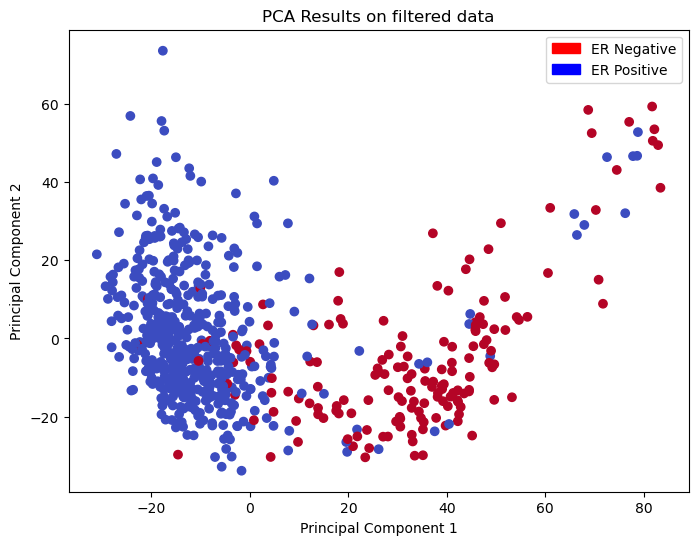

Principal Components:
[[-0.12610968 -0.1438398  -0.1254625  ... -0.00503426 -0.00614197
  -0.00779519]
 [-0.06209599  0.02254187  0.01350565 ...  0.01464468  0.01171446
   0.00578805]]


In [80]:
#Two Color, fully filtered data PCA (Blue = Positive ER, Red = Negative ER)
pca = PCA(n_components=2)  
pca_result = pca.fit_transform(ERfinaldf)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

color_map = {'Positive': 0, 'Negative': 1}

ERmetadf['Color'] = ERmetadf['ER'].map(color_map)

print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=ERmetadf['Color'], cmap='coolwarm')
plt.title("PCA Results on filtered data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
red_patch = mpatches.Patch(color='red', label='ER Negative')
blue_patch = mpatches.Patch(color='blue', label='ER Positive')
plt.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.show()

print("Principal Components:")
print(pca.components_)

In [105]:
#Prepping PAM50 Colorscheme
metadf['PAM50'] = metadf['PAM50'].replace('nan', np.nan)
PAM50metadf = metadf.dropna(subset=['PAM50'])
color_map = {'LumA': "blue", 'LumB': "green",'Her2': "pink", "HER2": "pink", "Basal":"red", "Normal": "black"}
colors = list(PAM50metadf['PAM50'].map(color_map))

In [ ]:
#Prepping PAM50FinalDf for PCA
PAM50finaldf = finaldf.loc[PAM50metadf.index] #Removes all rows with NA PAM50 values from finaldf

(783, 2000)

Explained variance ratio by each component:
[0.17853079 0.09401146]


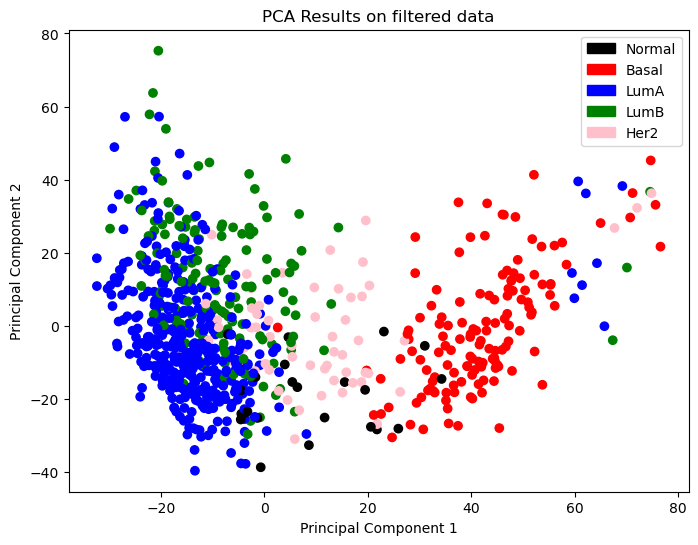

Principal Components:
[[-0.12298456 -0.14711011 -0.12647004 ... -0.00557426 -0.00640191
  -0.00753839]
 [-0.0630785   0.00522497  0.00383047 ...  0.01231925  0.00796755
   0.00426389]]


In [109]:
#PCA of fully filtered data
ca = PCA(n_components=2)  
pca_result = pca.fit_transform(PAM50finaldf)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])


print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c= colors)
plt.title("PCA Results on filtered data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
black_patch = mpatches.Patch(color='black', label='Normal')
blue_patch = mpatches.Patch(color='blue', label='LumA')
green_patch = mpatches.Patch(color = "green", label = "LumB")
pink_patch = mpatches.Patch(color = "pink", label = 'Her2')
red_patch = mpatches.Patch(color = "red", label = "Basal")
plt.legend(handles=[black_patch, red_patch, blue_patch, green_patch, pink_patch], loc='upper right')
plt.show()

print("Principal Components:")
print(pca.components_)

In [ ]:
#Prepping ERproteincodingdf for color scheme
ERproteincodingdf = tnormdf.drop(["GENETYPE", "GENESYMBOL"]) 
ERproteincodingdf = ERproteincodingdf.loc[ERmetadf.index]

Explained variance ratio by each component:
[0.10732232 0.07225175]


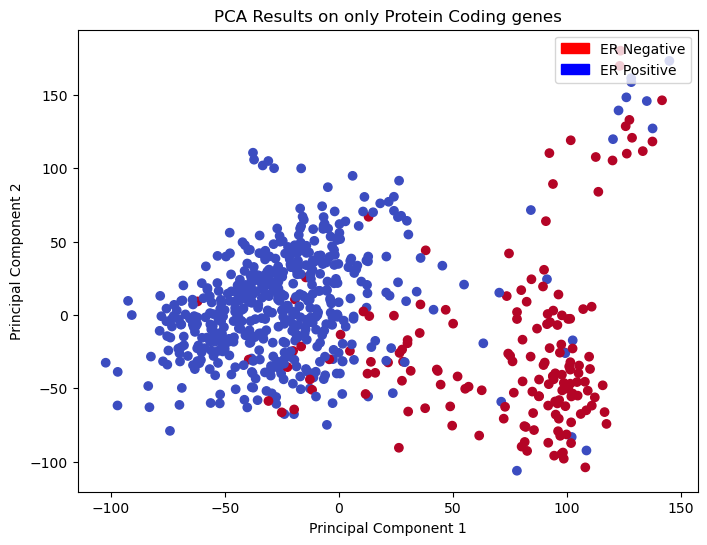

Principal Components:
[[ 0.00577007  0.00210879  0.0012453  ...  0.          0.00050624
   0.00365662]
 [ 0.00174964  0.02307678 -0.00681683 ...  0.          0.00335261
  -0.00058725]]


In [ ]:
#PCA on all Protein coding genes
pca = PCA(n_components=2)  
pca_result = pca.fit_transform(ERproteincodingdf)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=ERmetadf['Color'], cmap='coolwarm')
plt.title("PCA Results on All Protein Coding genes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
red_patch = mpatches.Patch(color='red', label='ER Negative')
blue_patch = mpatches.Patch(color='blue', label='ER Positive')
plt.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.show()

print("Principal Components:")
print(pca.components_)

In [110]:
#Prepping PAM50proteincodingdf for PCA
PAM50proteincodingdf = tnormdf.loc[PAM50metadf.index]

Explained variance ratio by each component:
[0.10889832 0.07004751]


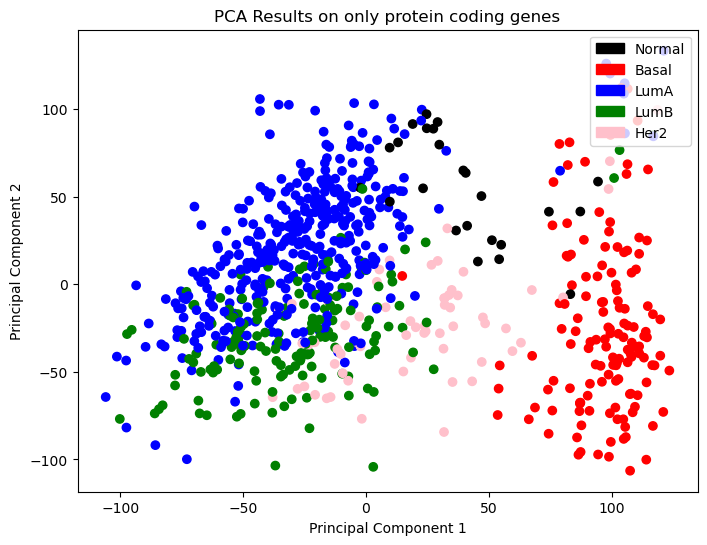

Principal Components:
[[ 0.00625032  0.00259489  0.00163717 ...  0.          0.00053835
   0.0033419 ]
 [ 0.00292304  0.0274753  -0.00660505 ...  0.          0.00388417
  -0.00137311]]


In [112]:
#PCA of protein coding genes
ca = PCA(n_components=2)  
pca_result = pca.fit_transform(PAM50proteincodingdf)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])


print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c= colors)
plt.title("PCA Results on only protein coding genes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
black_patch = mpatches.Patch(color='black', label='Normal')
blue_patch = mpatches.Patch(color='blue', label='LumA')
green_patch = mpatches.Patch(color = "green", label = "LumB")
pink_patch = mpatches.Patch(color = "pink", label = 'Her2')
red_patch = mpatches.Patch(color = "red", label = "Basal")
plt.legend(handles=[black_patch, red_patch, blue_patch, green_patch, pink_patch], loc='upper right')
plt.show()

print("Principal Components:")
print(pca.components_)

In [ ]:
#Prepping ERnormdf for color scheme
ERnormdf = normdf.T.drop(["GENETYPE", "GENESYMBOL"])
ERnormdf = ERnormdf.loc[ERmetadf.index]

Explained variance ratio by each component:
[0.10880292 0.07885161]


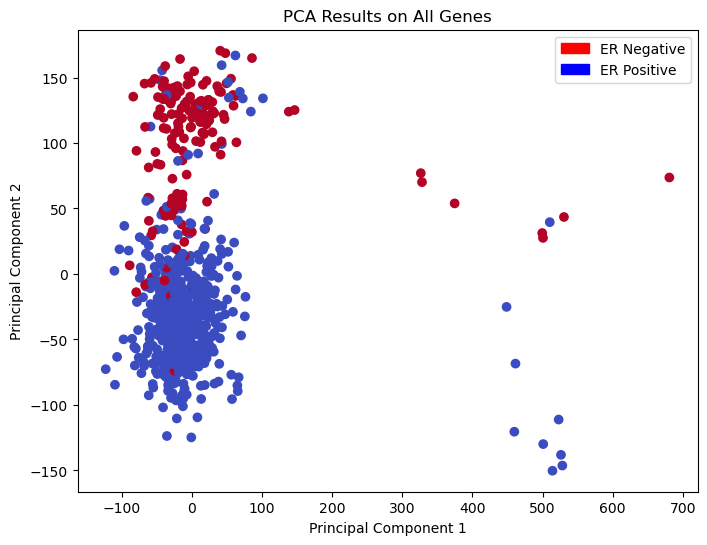

Principal Components:
[[ 0.00028333  0.00772955 -0.00213465 ...  0.          0.00247874
  -0.00133513]
 [ 0.00434139 -0.00099144  0.00173091 ... -0.         -0.00026237
   0.00339677]]


In [79]:
#PCA on all Genes
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(ERnormdf)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=ERmetadf['Color'], cmap='coolwarm')
plt.title("PCA Results on All Genes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
red_patch = mpatches.Patch(color='red', label='ER Negative')
blue_patch = mpatches.Patch(color='blue', label='ER Positive')
plt.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.show()

print("Principal Components:")
print(pca.components_)

In [113]:
#Prepping PAM50normdf for PCA
PAM50normdf = normdf.T.drop(["GENETYPE", "GENESYMBOL"])
PAM50normdf = PAM50normdf.loc[PAM50metadf.index]

Explained variance ratio by each component:
[0.0997269  0.08081518]


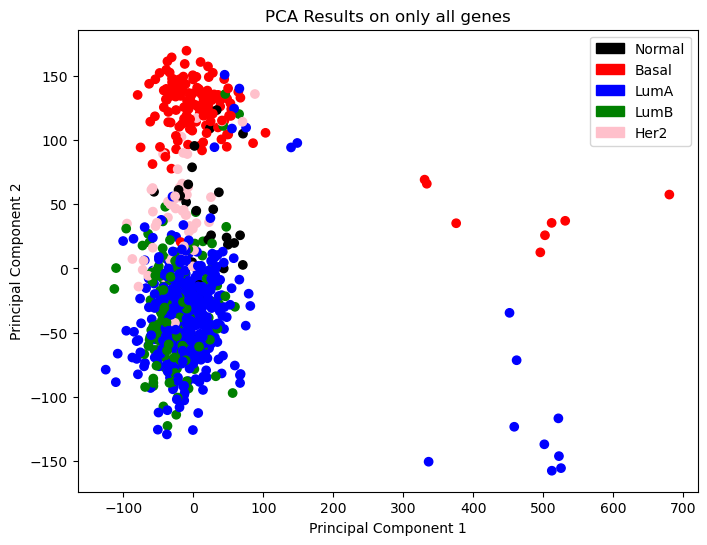

Principal Components:
[[ 0.00075862  0.00822293 -0.00214422 ...  0.          0.00266531
  -0.00143063]
 [ 0.00459812 -0.00027544  0.00190765 ...  0.         -0.00020668
   0.003128  ]]


In [114]:
#PCA of all genes
ca = PCA(n_components=2)  
pca_result = pca.fit_transform(PAM50normdf)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])


print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c= colors)
plt.title("PCA Results on only all genes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
black_patch = mpatches.Patch(color='black', label='Normal')
blue_patch = mpatches.Patch(color='blue', label='LumA')
green_patch = mpatches.Patch(color = "green", label = "LumB")
pink_patch = mpatches.Patch(color = "pink", label = 'Her2')
red_patch = mpatches.Patch(color = "red", label = "Basal")
plt.legend(handles=[black_patch, red_patch, blue_patch, green_patch, pink_patch], loc='upper right')
plt.show()

print("Principal Components:")
print(pca.components_)